In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob
from PIL import Image
import random
metadata = pd.read_csv("metadata.csv")

# Chemokines GRADCAM Interpretation

/opt/anaconda3/envs/rules-chatbot/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 614 variables whereas the saved optimizer has 1226 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 2590 chemokines images in metadata.
Found 2590 chemokines images with all 6 channels
Selected chemokines image: E23_s2, MCP-4-
Using treatment_conc: 0.0999999999999999 for E23_s2 (MCP-4-)
Using layer: conv2d for GradCAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: 0


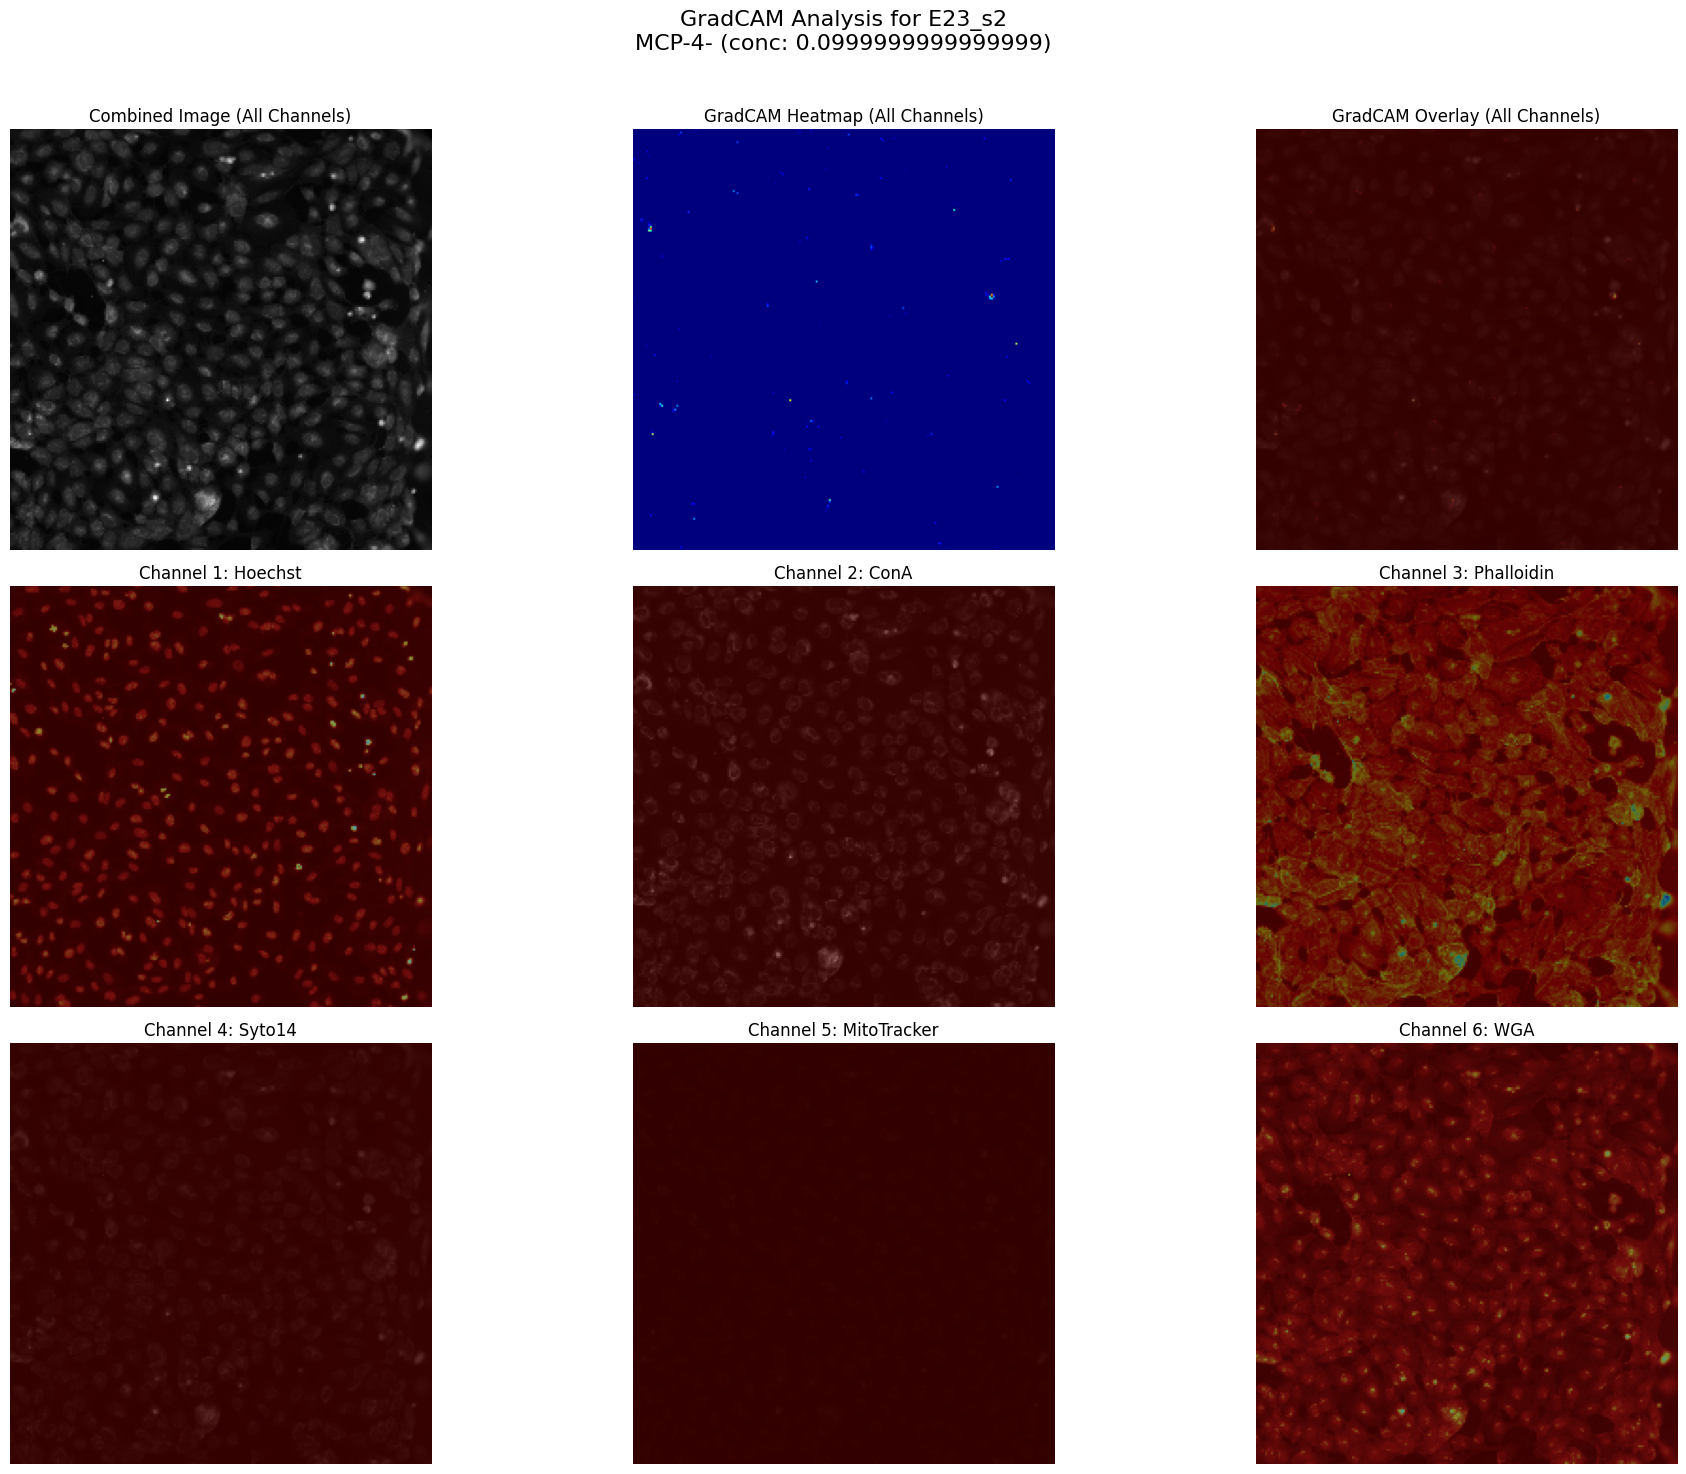

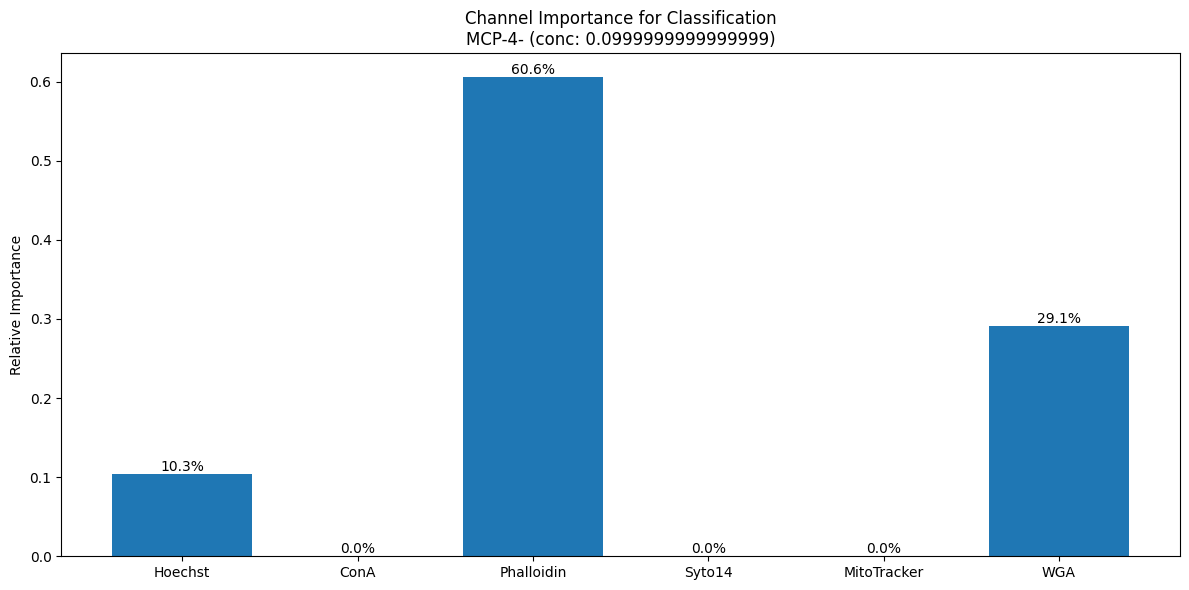

In [27]:

# chemokines model
model = tf.keras.models.load_model("model_treatment_conc_chemokines.keras")
image_base_path = "immune_images"

# Define chemokines treatments based on your categorization
CHEMOKINES = [
    "CCL1", "CCL4", "CCL14a", "CCL21", "CXCL16", 
    "MIP-1a", "MIP-3a", "MIP-3b", 
    "MCP-1", "MCP-3", "MCP-4-"
]

# Function to find all channel images for a well/site
def find_channel_images(well, site):
    pattern = f"{well}_s{site}_w*.png"
    channel_files = sorted(glob.glob(os.path.join(image_base_path, pattern)))
    
    # If not found, try alternative pattern
    if not channel_files:
        pattern = f"{well}_{site}_w*.png"
        channel_files = sorted(glob.glob(os.path.join(image_base_path, pattern)))
    
    return channel_files

# Function to create combined 6-channel image from individual channel files
def create_6channel_input(channel_files):
    # Make sure we have exactly 6 channel files
    if len(channel_files) != 6:
        raise ValueError(f"Expected 6 channel files, got {len(channel_files)}")
    
    # Load the first image to get dimensions
    first_img = np.array(Image.open(channel_files[0]))
    height, width = first_img.shape
    
    # Create a 6-channel image of the right size for the model (224x224x6)
    combined_img = np.zeros((224, 224, 6), dtype=np.float32)
    
    # Load each channel, resize and normalize
    for i, channel_path in enumerate(channel_files):
        channel_img = np.array(Image.open(channel_path))
        # Resize to 224x224
        channel_img_resized = cv2.resize(channel_img, (224, 224))
        # Normalize to [0, 1]
        channel_img_normalized = channel_img_resized / 255.0
        # Add to the combined image
        combined_img[:, :, i] = channel_img_normalized
    
    return combined_img

# GradCAM implementation for dual input model
def make_gradcam_heatmap(img_input, treatment_conc_input, model, layer_name, channel_index=None, pred_index=None):
    """
    Generate GradCAM heatmap for a specific input image.
    
    Args:
        img_input: The 6-channel image input (batch dimension included)
        treatment_conc_input: The treatment concentration input
        model: The Keras model
        layer_name: Name of the layer to use for GradCAM
        channel_index: Index of the channel to analyze (if None, uses all channels)
        pred_index: Index of the class to analyze (if None, uses the predicted class)
    
    Returns:
        The GradCAM heatmap
    """
    # Create model for GradCAM
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs[0], model.inputs[1]],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Create input focused on a single channel if specified
    if channel_index is not None:
        # Create a copy of the input with zeros in all channels except the specified one
        channel_input = np.zeros_like(img_input)
        channel_input[..., channel_index:channel_index+1] = img_input[..., channel_index:channel_index+1]
        img_input = channel_input
    
    # Calculate gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model([img_input, treatment_conc_input])
        
        # Use the predicted class if none is specified
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        
        # Get the score for the target class
        target_class = predictions[:, pred_index]
    
    # Gradient of the target class with respect to the output feature map
    grads = tape.gradient(target_class, conv_output)
    
    # Calculate importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps with importance
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

# Function to find chemokines images from metadata using the correct chemokines list
def find_chemokines_images():
    """Find well-site combinations with chemokines treatment"""
    # Filter metadata for exact chemokines treatments
    chemokines_df = metadata[metadata['treatment'].isin(CHEMOKINES)]
    
    if chemokines_df.empty:
        print(f"No chemokines treatments found in metadata. Looking for these treatments: {CHEMOKINES}")
        # Try partial matching as fallback
        chemokines_df = metadata[metadata['treatment'].str.contains('|'.join(CHEMOKINES), case=False, na=False)]
        
        if chemokines_df.empty:
            print("No chemokines found with partial matching either.")
            return []
        else:
            print(f"Found {len(chemokines_df)} chemokines images using partial matching.")
    else:
        print(f"Found {len(chemokines_df)} chemokines images in metadata.")
    
    # Create well-site combinations
    well_sites = []
    
    for _, row in chemokines_df.iterrows():
        well = row['well']
        site = str(row['site'])
        treatment = row['treatment']
        treatment_conc = row['treatment_conc']
        
        # Check if image files exist
        channel_files = find_channel_images(well, site)
        
        if len(channel_files) == 6:
            well_sites.append({
                'well': well,
                'site': site,
                'treatment': treatment,
                'treatment_conc': treatment_conc
            })
    
    print(f"Found {len(well_sites)} chemokines images with all 6 channels")
    return well_sites

# Function to visualize GradCAM for all 6 channels
def visualize_gradcam_for_channels(well, site, treatment=None, treatment_conc=None):
    """
    Visualize GradCAM for all 6 channels of a specific well-site combination.
    
    Args:
        well: Well identifier (e.g., 'AA03')
        site: Site number (e.g., 1)
        treatment: Optional treatment name for display purposes
        treatment_conc: Optional treatment concentration value to use (default uses actual value from metadata)
    """
    # Channel names
    channel_names = ["Hoechst", "ConA", "Phalloidin", "Syto14", "MitoTracker", "WGA"]
    
    # Find all channel images
    channel_files = find_channel_images(well, site)
    
    if len(channel_files) != 6:
        print(f"Expected 6 channel files for {well}_s{site}, found {len(channel_files)}")
        return
    
    # Create 6-channel input
    img_6channel = create_6channel_input(channel_files)
    
    # Add batch dimension
    img_input = np.expand_dims(img_6channel, axis=0)
    
    # Get treatment_conc from metadata if not provided
    if treatment_conc is None:
        # Find the treatment_conc value in metadata
        try:
            row = metadata[(metadata['well'] == well) & (metadata['site'] == int(site))]
            if not row.empty:
                treatment_conc = float(row['treatment_conc'].values[0])
                if treatment is None:
                    treatment = row['treatment'].values[0]
            else:
                treatment_conc = 0.0
                if treatment is None:
                    treatment = "Unknown"
        except Exception as e:
            print(f"Error getting treatment_conc from metadata: {e}")
            treatment_conc = 0.0
            if treatment is None:
                treatment = "Unknown"
    
    # Create treatment concentration input
    treatment_conc_input = np.array([[float(treatment_conc)]])
    print(f"Using treatment_conc: {treatment_conc} for {well}_s{site} ({treatment})")
    
    # Find the last convolutional layer for GradCAM
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break
    
    if not last_conv_layer:
        # Fallback to finding a layer with 'conv' in the name
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                last_conv_layer = layer.name
                break
    
    if not last_conv_layer:
        print("Could not find a convolutional layer for GradCAM")
        return
    
    print(f"Using layer: {last_conv_layer} for GradCAM")
    
    # Make a prediction to get the class
    try:
        prediction = model.predict([img_input, treatment_conc_input])
        predicted_class = np.argmax(prediction)
        print(f"Predicted class: {predicted_class}")
    except Exception as e:
        print(f"Error making prediction: {e}")
        predicted_class = 0  # Default to class 0
    
    # Create figure for GradCAM visualization
    plt.figure(figsize=(20, 15))
    
    # Create full image GradCAM (using all channels)
    try:
        heatmap_all = make_gradcam_heatmap(
            img_input,
            treatment_conc_input,
            model,
            last_conv_layer,
            channel_index=None,
            pred_index=predicted_class
        )
        
        # Resize heatmap to match image size
        heatmap_all_resized = cv2.resize(heatmap_all, (224, 224))
        
        # Convert heatmap to RGB
        heatmap_all_rgb = np.uint8(255 * heatmap_all_resized)
        heatmap_all_rgb = cv2.applyColorMap(heatmap_all_rgb, cv2.COLORMAP_JET)
        
        # Overlay on grayscale version of the image (average of all channels)
        img_gray = np.mean(img_6channel, axis=2)
        img_gray_rgb = np.stack([img_gray, img_gray, img_gray], axis=2)
        img_gray_rgb = np.uint8(255 * img_gray_rgb)
        
        # Superimpose heatmap
        superimposed_all = heatmap_all_rgb * 0.4 + img_gray_rgb * 0.6
        superimposed_all = np.clip(superimposed_all, 0, 255).astype(np.uint8)
        
        # Display combined image and heatmap
        plt.subplot(3, 3, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title("Combined Image (All Channels)")
        plt.axis('off')
        
        plt.subplot(3, 3, 2)
        plt.imshow(heatmap_all_resized, cmap='jet')
        plt.title("GradCAM Heatmap (All Channels)")
        plt.axis('off')
        
        plt.subplot(3, 3, 3)
        plt.imshow(superimposed_all)
        plt.title("GradCAM Overlay (All Channels)")
        plt.axis('off')
    except Exception as e:
        print(f"Error creating combined GradCAM: {e}")
    
    # Generate GradCAM for each individual channel
    for i in range(6):
        try:
            # Generate heatmap for this channel only
            heatmap = make_gradcam_heatmap(
                img_input,
                treatment_conc_input,
                model,
                last_conv_layer,
                channel_index=i,
                pred_index=predicted_class
            )
            
            # Resize heatmap
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            
            # Convert to RGB for visualization
            heatmap_rgb = np.uint8(255 * heatmap_resized)
            heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
            
            # Get the individual channel for visualization
            channel_img = img_6channel[:, :, i]
            channel_img_rgb = np.stack([channel_img, channel_img, channel_img], axis=2)
            channel_img_rgb = np.uint8(255 * channel_img_rgb)
            
            # Superimpose heatmap on channel image
            superimposed = heatmap_rgb * 0.4 + channel_img_rgb * 0.6
            superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
            
            # Display channel image and heatmap
            plt.subplot(3, 3, i+4)
            plt.imshow(superimposed)
            plt.title(f"Channel {i+1}: {channel_names[i]}")
            plt.axis('off')
            
        except Exception as e:
            print(f"Error creating GradCAM for channel {i+1}: {e}")
            plt.subplot(3, 3, i+4)
            plt.text(0.5, 0.5, f"Error", ha='center', va='center')
            plt.axis('off')
    
    plt.suptitle(f"GradCAM Analysis for {well}_s{site}\n{treatment} (conc: {treatment_conc})", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Calculate and display channel importance based on GradCAM
    try:
        channel_importance = []
        
        for i in range(6):
            # Generate heatmap for this channel only
            heatmap = make_gradcam_heatmap(
                img_input,
                treatment_conc_input,
                model, 
                last_conv_layer,
                channel_index=i,
                pred_index=predicted_class
            )
            
            # Calculate importance as mean activation
            importance = np.mean(heatmap)
            channel_importance.append(importance)
        
        # Normalize importance scores
        channel_importance = np.array(channel_importance)
        total = np.sum(channel_importance)
        if total > 0:
            channel_importance = channel_importance / total
        
        # Plot channel importance
        plt.figure(figsize=(12, 6))
        bars = plt.bar(channel_names, channel_importance)
        plt.ylabel('Relative Importance')
        plt.title(f'Channel Importance for Classification\n{treatment} (conc: {treatment_conc})')
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height*100:.1f}%',
                     ha='center', va='bottom', rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        return channel_importance
    except Exception as e:
        print(f"Error calculating channel importance: {e}")
        return None

# Check if the treatment_subcategory column exists in metadata
if 'treatment_subcategory' not in metadata.columns:
    # Define treatment categories mapping
    immune_modulators = {
        "Pro-inflammatory Cytokines": [
            "TNF-alpha", "IL-1-beta", "IL-6", "IL-17A", "IL-17B", "IL-17E", "IL-17F", "IL-12", "IL-23"
        ],
        "Anti-inflammatory Cytokines": [
            "IL-4", "IL-10", "IL-13", "IL-27", "IL-35"
        ],
        "Chemokines": [
            "CCL1", "CCL4", "CCL14a", "CCL21", "CXCL16", "MIP-1a", "MIP-3a", "MIP-3b", "MCP-1", "MCP-3", "MCP-4-"
        ],
        "Interferons": [
            "IFN-alpha-A", "IFN-beta", "IFN-gamma", "IFN-omega"
        ],
        "Toll-Like Receptor (TLR) Agonists": [
            "TLR-4", "Poly_IC_HMW", "Poly_IC_LMW", "ssRNA40", "LPS_EK"
        ],
        "Macrophage & T-cell Regulators": [
            "M-CSF", "GM-CSF", "OX40", "HVEM", "CD40-Ligand", "CTLA-4"
        ],
        "Complement System Activators": [
            "C5a", "Complement C2", "Factor-D", "Factor-H", "Factor-X"
        ]
    }

    # Create a lookup dictionary for fast mapping
    immune_treatment_to_category = {}
    for subcategory, treatments in immune_modulators.items():
        for treatment in treatments:
            immune_treatment_to_category[treatment] = ("Immune System Modulators", subcategory)

    # Function to assign category and subcategory
    def categorize_treatment(treatment):
        if treatment == "EMPTY":
            return "Control", "Control"  # Control case
        return immune_treatment_to_category.get(treatment, ("N/A", "N/A"))  # Assign category if found, else N/A

    # Apply the categorization to the dataframe
    metadata[["treatment_category", "treatment_subcategory"]] = metadata["treatment"].apply(lambda x: pd.Series(categorize_treatment(x)))

# Function to find chemokines using the treatment_subcategory column
def find_chemokines_using_subcategory():
    """Find well-site combinations with chemokines treatment using subcategory"""
    try:
        # Filter metadata for chemokines subcategory
        chemokines_df = metadata[metadata['treatment_subcategory'] == 'Chemokines']
        
        if chemokines_df.empty:
            print("No chemokines treatments found in treatment_subcategory column.")
            return []
        else:
            print(f"Found {len(chemokines_df)} chemokines images using treatment_subcategory.")
        
        # Create well-site combinations
        well_sites = []
        
        for _, row in chemokines_df.iterrows():
            well = row['well']
            site = str(row['site'])
            treatment = row['treatment']
            treatment_conc = row['treatment_conc']
            
            # Check if image files exist
            channel_files = find_channel_images(well, site)
            
            if len(channel_files) == 6:
                well_sites.append({
                    'well': well,
                    'site': site,
                    'treatment': treatment,
                    'treatment_conc': treatment_conc
                })
        
        print(f"Found {len(well_sites)} chemokines images with all 6 channels")
        return well_sites
    except Exception as e:
        print(f"Error finding chemokines using subcategory: {e}")
        return []

# Main function to analyze chemokines images
def analyze_chemokines_images(custom_treatment_conc=None):
    """
    Analyze chemokines images with GradCAM.
    
    Args:
        custom_treatment_conc: Optional custom treatment concentration to use
    """
    # Try different methods to find chemokines images
    chemokines_images = find_chemokines_images()
    
    if not chemokines_images:
        # Try using the subcategory column
        print("Attempting to find chemokines using treatment_subcategory...")
        chemokines_images = find_chemokines_using_subcategory()
    
    if not chemokines_images:
        print("No chemokines images found with all 6 channels.")
        
        # Print all unique treatments in metadata to help debug
        unique_treatments = metadata['treatment'].unique()
        print(f"Available treatments in metadata: {unique_treatments}")
        
        # Fallback to using any random well-site with 6 channels
        print("Falling back to any available well-site with 6 channels...")
        all_files = glob.glob(os.path.join(image_base_path, "*.png"))
        well_sites = set()
        
        for img_path in all_files:
            filename = os.path.basename(img_path)
            parts = filename.split('_')
            
            if len(parts) >= 2:
                well = parts[0]
                
                # Try to find site part
                site = None
                for part in parts:
                    if part.startswith('s') and len(part) > 1:
                        site = part[1:]
                        break
                
                if site:
                    # Check if all 6 channels exist
                    channel_files = find_channel_images(well, site)
                    if len(channel_files) == 6:
                        well_sites.add((well, site))
        
        if well_sites:
            well, site = random.choice(list(well_sites))
            print(f"Selected random well: {well}, site: {site}")
            
            # Try to get treatment from metadata
            try:
                row = metadata[(metadata['well'] == well) & (metadata['site'] == int(site))]
                if not row.empty:
                    treatment = row['treatment'].values[0]
                else:
                    treatment = "Unknown"
            except:
                treatment = "Unknown"
            
            # Visualize GradCAM using specified treatment_conc or None to use value from metadata
            visualize_gradcam_for_channels(well, site, treatment, custom_treatment_conc)
            return
        else:
            print("No images with 6 channels found.")
            return
    
    # Select a random chemokines image
    selected_image = random.choice(chemokines_images)
    well = selected_image['well']
    site = selected_image['site']
    treatment = selected_image['treatment']
    
    # Use custom treatment_conc if provided, otherwise use the actual one
    treatment_conc = custom_treatment_conc if custom_treatment_conc is not None else selected_image['treatment_conc']
    
    print(f"Selected chemokines image: {well}_s{site}, {treatment}")
    
    # Visualize GradCAM for this image
    visualize_gradcam_for_channels(well, site, treatment, treatment_conc)

# Execute the analysis with default treatment_conc
analyze_chemokines_images()

# Interferons GRADCAM Interpretation

/opt/anaconda3/envs/rules-chatbot/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 614 variables whereas the saved optimizer has 1226 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 1150 interferons images in metadata.
Found 1134 interferons images with all 6 channels
Selected interferon image: Y03_s1, IFN-gamma
Using treatment_conc: 0.01 for Y03_s1 (IFN-gamma)
Using layer: conv2d_1 for GradCAM
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: 0
Predicted treatment: EMPTY


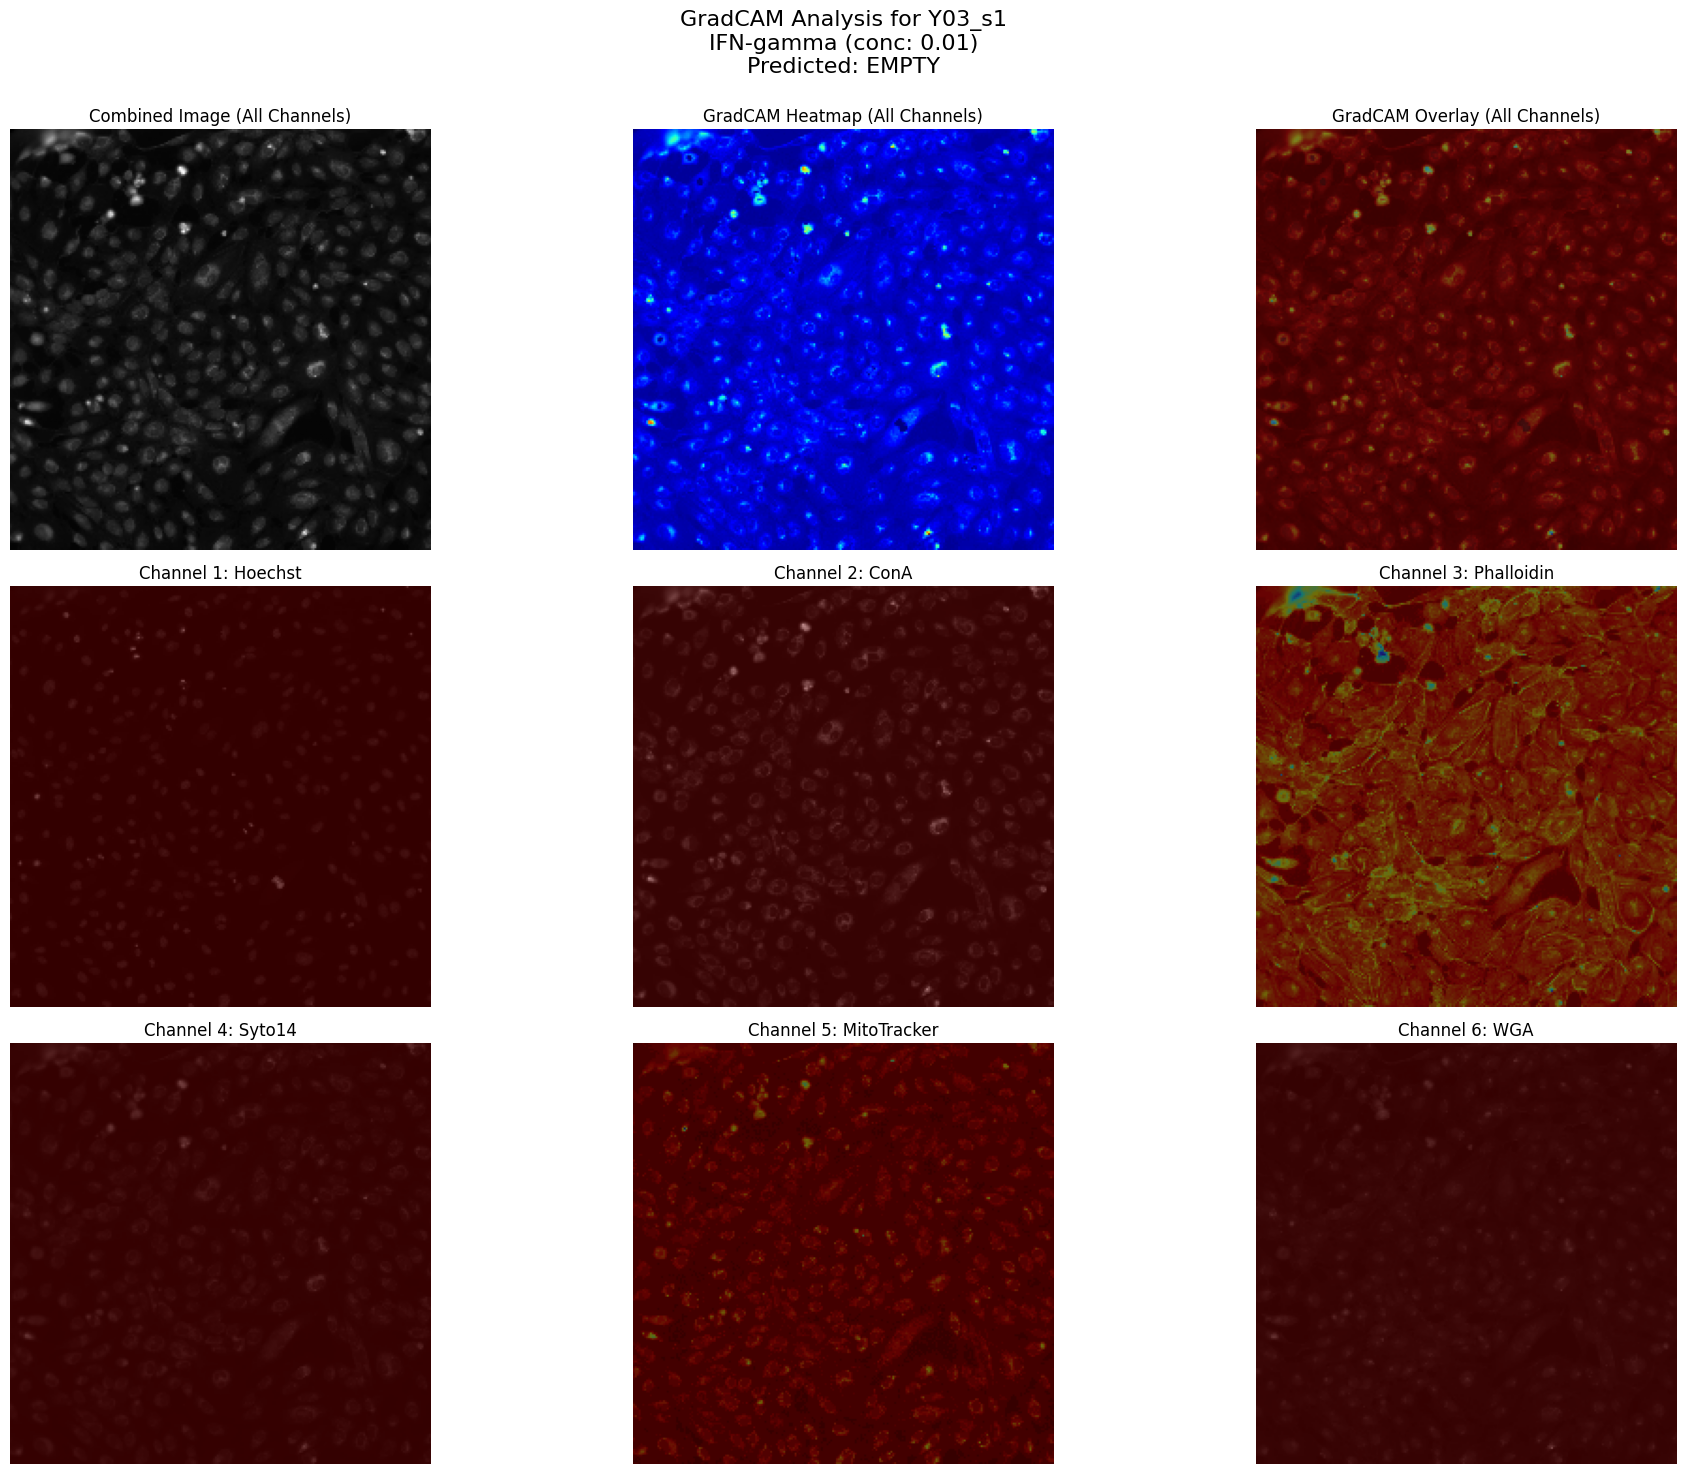

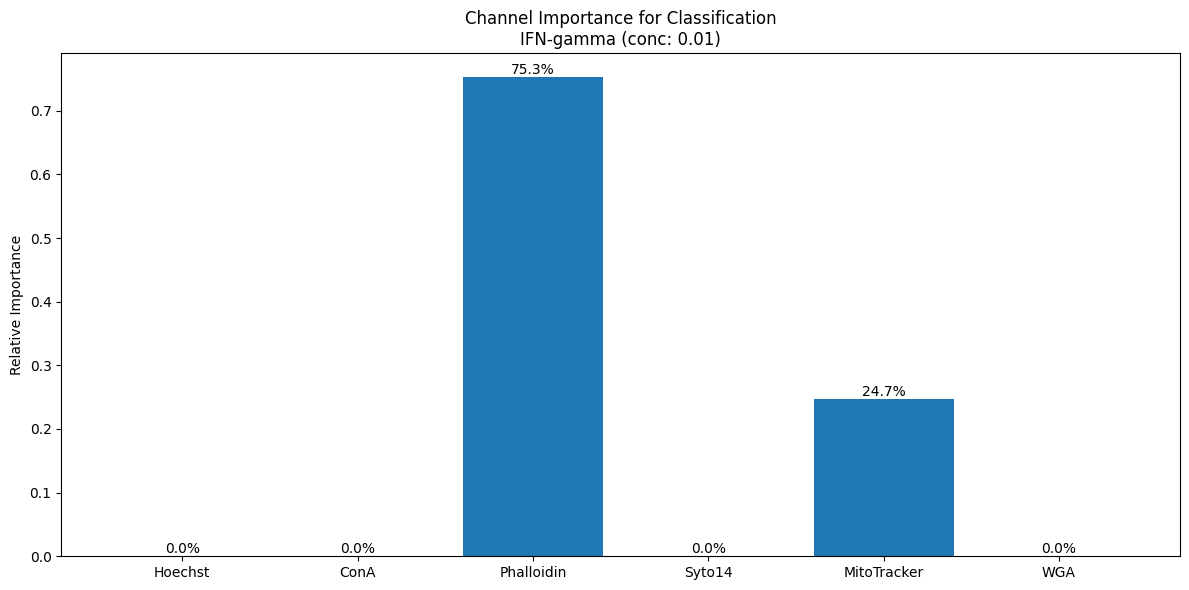

In [28]:

model = tf.keras.models.load_model("model_treatment_conc_interferons.keras")

# Define interferons treatments based on the categorization
INTERFERONS = [
    "IFN-alpha-A", "IFNB-1", "IFN-gamma", "IFN-omega"
]

# Function to find all channel images for a well-site
def find_channel_images(well, site):
    pattern = f"{well}_s{site}_w*.png"
    channel_files = sorted(glob.glob(os.path.join(image_base_path, pattern)))
    
    # If not found, try alternative pattern
    if not channel_files:
        pattern = f"{well}_{site}_w*.png"
        channel_files = sorted(glob.glob(os.path.join(image_base_path, pattern)))
    
    return channel_files

# Function to create combined 6-channel image from individual channel files
def create_6channel_input(channel_files):
    # Make sure we have exactly 6 channel files
    if len(channel_files) != 6:
        raise ValueError(f"Expected 6 channel files, got {len(channel_files)}")
    
    # Load the first image to get dimensions
    first_img = np.array(Image.open(channel_files[0]))
    height, width = first_img.shape
    
    # Create a 6-channel image of the right size for the model (224x224x6)
    combined_img = np.zeros((224, 224, 6), dtype=np.float32)
    
    # Load each channel, resize and normalize
    for i, channel_path in enumerate(channel_files):
        channel_img = np.array(Image.open(channel_path))
        # Resize to 224x224
        channel_img_resized = cv2.resize(channel_img, (224, 224))
        # Normalize to [0, 1]
        channel_img_normalized = channel_img_resized / 255.0
        # Add to the combined image
        combined_img[:, :, i] = channel_img_normalized
    
    return combined_img

# GradCAM implementation for dual input model
def make_gradcam_heatmap(img_input, treatment_conc_input, model, layer_name, channel_index=None, pred_index=None):
    """
    Generate GradCAM heatmap for a specific input image.
    
    Args:
        img_input: The 6-channel image input (batch dimension included)
        treatment_conc_input: The treatment concentration input
        model: The Keras model
        layer_name: Name of the layer to use for GradCAM
        channel_index: Index of the channel to analyze (if None, uses all channels)
        pred_index: Index of the class to analyze (if None, uses the predicted class)
    
    Returns:
        The GradCAM heatmap
    """
    # Create model for GradCAM
    grad_model = tf.keras.models.Model(
        inputs=[model.inputs[0], model.inputs[1]],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    
    # Create input focused on a single channel if specified
    if channel_index is not None:
        # Create a copy of the input with zeros in all channels except the specified one
        channel_input = np.zeros_like(img_input)
        channel_input[..., channel_index:channel_index+1] = img_input[..., channel_index:channel_index+1]
        img_input = channel_input
    
    # Calculate gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model([img_input, treatment_conc_input])
        
        # Use the predicted class if none is specified
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        
        # Get the score for the target class
        target_class = predictions[:, pred_index]
    
    # Gradient of the target class with respect to the output feature map
    grads = tape.gradient(target_class, conv_output)
    
    # Calculate importance weights
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weight feature maps with importance
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    
    return heatmap.numpy()

# Function to find interferons images from metadata
def find_interferons_images():
    """Find well-site combinations with interferons treatment"""
    # Filter metadata for exact interferons treatments
    interferons_df = metadata[metadata['treatment'].isin(INTERFERONS)]
    
    if interferons_df.empty:
        print(f"No interferons treatments found in metadata. Looking for these treatments: {INTERFERONS}")
        return []
    else:
        print(f"Found {len(interferons_df)} interferons images in metadata.")
    
    # Create well-site combinations
    well_sites = []
    
    for _, row in interferons_df.iterrows():
        well = row['well']
        site = str(row['site'])
        treatment = row['treatment']
        treatment_conc = row['treatment_conc']
        
        # Check if image files exist
        channel_files = find_channel_images(well, site)
        
        if len(channel_files) == 6:
            well_sites.append({
                'well': well,
                'site': site,
                'treatment': treatment,
                'treatment_conc': treatment_conc
            })
    
    print(f"Found {len(well_sites)} interferons images with all 6 channels")
    return well_sites

# Function to visualize GradCAM for all 6 channels
def visualize_gradcam_for_channels(well, site, treatment=None, treatment_conc=None):
    """
    Visualize GradCAM for all 6 channels of a specific well-site combination.
    
    Args:
        well: Well identifier (e.g., 'AA03')
        site: Site number (e.g., 1)
        treatment: Optional treatment name for display purposes
        treatment_conc: Optional treatment concentration value to use (default uses actual value from metadata)
    """
    # Channel names
    channel_names = ["Hoechst", "ConA", "Phalloidin", "Syto14", "MitoTracker", "WGA"]
    
    # Find all channel images
    channel_files = find_channel_images(well, site)
    
    if len(channel_files) != 6:
        print(f"Expected 6 channel files for {well}_s{site}, found {len(channel_files)}")
        return
    
    # Create 6-channel input
    img_6channel = create_6channel_input(channel_files)
    
    # Add batch dimension
    img_input = np.expand_dims(img_6channel, axis=0)
    
    # Get treatment_conc from metadata if not provided
    if treatment_conc is None:
        # Find the treatment_conc value in metadata
        try:
            row = metadata[(metadata['well'] == well) & (metadata['site'] == int(site))]
            if not row.empty:
                treatment_conc = float(row['treatment_conc'].values[0])
                if treatment is None:
                    treatment = row['treatment'].values[0]
            else:
                treatment_conc = 0.0
                if treatment is None:
                    treatment = "Unknown"
        except Exception as e:
            print(f"Error getting treatment_conc from metadata: {e}")
            treatment_conc = 0.0
            if treatment is None:
                treatment = "Unknown"
    
    # Create treatment concentration input
    treatment_conc_input = np.array([[float(treatment_conc)]])
    print(f"Using treatment_conc: {treatment_conc} for {well}_s{site} ({treatment})")
    
    # Find the last convolutional layer for GradCAM
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break
    
    if not last_conv_layer:
        # Fallback to finding a layer with 'conv' in the name
        for layer in reversed(model.layers):
            if 'conv' in layer.name.lower():
                last_conv_layer = layer.name
                break
    
    if not last_conv_layer:
        print("Could not find a convolutional layer for GradCAM")
        return
    
    print(f"Using layer: {last_conv_layer} for GradCAM")
    
    # Make a prediction to get the class
    try:
        prediction = model.predict([img_input, treatment_conc_input])
        predicted_class = np.argmax(prediction)
        print(f"Predicted class: {predicted_class}")
        
        # Map the class index to the corresponding treatment
        class_labels = ["EMPTY", "IFN-alpha-A", "IFN-gamma", "IFN-omega", "IFNB-1"]
        if predicted_class < len(class_labels):
            predicted_treatment = class_labels[predicted_class]
            print(f"Predicted treatment: {predicted_treatment}")
        else:
            predicted_treatment = f"Class {predicted_class}"
            
    except Exception as e:
        print(f"Error making prediction: {e}")
        predicted_class = 0  # Default to class 0
        predicted_treatment = "Unknown"
    
    # Create figure for GradCAM visualization
    plt.figure(figsize=(20, 15))
    
    # Create full image GradCAM (using all channels)
    try:
        heatmap_all = make_gradcam_heatmap(
            img_input,
            treatment_conc_input,
            model,
            last_conv_layer,
            channel_index=None,
            pred_index=predicted_class
        )
        
        # Resize heatmap to match image size
        heatmap_all_resized = cv2.resize(heatmap_all, (224, 224))
        
        # Convert heatmap to RGB
        heatmap_all_rgb = np.uint8(255 * heatmap_all_resized)
        heatmap_all_rgb = cv2.applyColorMap(heatmap_all_rgb, cv2.COLORMAP_JET)
        
        # Overlay on grayscale version of the image (average of all channels)
        img_gray = np.mean(img_6channel, axis=2)
        img_gray_rgb = np.stack([img_gray, img_gray, img_gray], axis=2)
        img_gray_rgb = np.uint8(255 * img_gray_rgb)
        
        # Superimpose heatmap
        superimposed_all = heatmap_all_rgb * 0.4 + img_gray_rgb * 0.6
        superimposed_all = np.clip(superimposed_all, 0, 255).astype(np.uint8)
        
        # Display combined image and heatmap
        plt.subplot(3, 3, 1)
        plt.imshow(img_gray, cmap='gray')
        plt.title("Combined Image (All Channels)")
        plt.axis('off')
        
        plt.subplot(3, 3, 2)
        plt.imshow(heatmap_all_resized, cmap='jet')
        plt.title("GradCAM Heatmap (All Channels)")
        plt.axis('off')
        
        plt.subplot(3, 3, 3)
        plt.imshow(superimposed_all)
        plt.title("GradCAM Overlay (All Channels)")
        plt.axis('off')
    except Exception as e:
        print(f"Error creating combined GradCAM: {e}")
    
    # Generate GradCAM for each individual channel
    for i in range(6):
        try:
            # Generate heatmap for this channel only
            heatmap = make_gradcam_heatmap(
                img_input,
                treatment_conc_input,
                model,
                last_conv_layer,
                channel_index=i,
                pred_index=predicted_class
            )
            
            # Resize heatmap
            heatmap_resized = cv2.resize(heatmap, (224, 224))
            
            # Convert to RGB for visualization
            heatmap_rgb = np.uint8(255 * heatmap_resized)
            heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
            
            # Get the individual channel for visualization
            channel_img = img_6channel[:, :, i]
            channel_img_rgb = np.stack([channel_img, channel_img, channel_img], axis=2)
            channel_img_rgb = np.uint8(255 * channel_img_rgb)
            
            # Superimpose heatmap on channel image
            superimposed = heatmap_rgb * 0.4 + channel_img_rgb * 0.6
            superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)
            
            # Display channel image and heatmap
            plt.subplot(3, 3, i+4)
            plt.imshow(superimposed)
            plt.title(f"Channel {i+1}: {channel_names[i]}")
            plt.axis('off')
            
        except Exception as e:
            print(f"Error creating GradCAM for channel {i+1}: {e}")
            plt.subplot(3, 3, i+4)
            plt.text(0.5, 0.5, f"Error", ha='center', va='center')
            plt.axis('off')
    
    plt.suptitle(f"GradCAM Analysis for {well}_s{site}\n{treatment} (conc: {treatment_conc})\nPredicted: {predicted_treatment}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Calculate and display channel importance based on GradCAM
    try:
        channel_importance = []
        
        for i in range(6):
            # Generate heatmap for this channel only
            heatmap = make_gradcam_heatmap(
                img_input,
                treatment_conc_input,
                model, 
                last_conv_layer,
                channel_index=i,
                pred_index=predicted_class
            )
            
            # Calculate importance as mean activation
            importance = np.mean(heatmap)
            channel_importance.append(importance)
        
        # Normalize importance scores
        channel_importance = np.array(channel_importance)
        total = np.sum(channel_importance)
        if total > 0:
            channel_importance = channel_importance / total
        
        # Plot channel importance
        plt.figure(figsize=(12, 6))
        bars = plt.bar(channel_names, channel_importance)
        plt.ylabel('Relative Importance')
        plt.title(f'Channel Importance for Classification\n{treatment} (conc: {treatment_conc})')
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height*100:.1f}%',
                     ha='center', va='bottom', rotation=0)
        
        plt.tight_layout()
        plt.show()
        
        return channel_importance
    except Exception as e:
        print(f"Error calculating channel importance: {e}")
        return None

# Main function to analyze interferons images
def analyze_interferons_images(custom_treatment_conc=None, specific_interferon=None):
    """
    Analyze interferons images with GradCAM.
    
    Args:
        custom_treatment_conc: Optional custom treatment concentration to use
        specific_interferon: Optional specific interferon to analyze (e.g., 'IFN-gamma')
    """
    # Find interferons images
    interferons_images = find_interferons_images()
    
    if not interferons_images:
        print("No interferons images found with all 6 channels.")
        return
    
    # Filter to a specific interferon if requested
    if specific_interferon:
        filtered_images = [img for img in interferons_images if img['treatment'] == specific_interferon]
        if filtered_images:
            interferons_images = filtered_images
            print(f"Filtered to {len(filtered_images)} images with treatment {specific_interferon}")
        else:
            print(f"No images found with treatment {specific_interferon}. Using all interferons.")
    
    # Select a random interferon image
    selected_image = random.choice(interferons_images)
    well = selected_image['well']
    site = selected_image['site']
    treatment = selected_image['treatment']
    
    # Use custom treatment_conc if provided, otherwise use the actual one
    treatment_conc = custom_treatment_conc if custom_treatment_conc is not None else selected_image['treatment_conc']
    
    print(f"Selected interferon image: {well}_s{site}, {treatment}")
    
    # Visualize GradCAM for this image
    visualize_gradcam_for_channels(well, site, treatment, treatment_conc)

# Execute the analysis with default treatment_conc
analyze_interferons_images()

# To analyze a specific interferon (e.g., 'IFN-gamma') with a custom treatment_conc:
# analyze_interferons_images(custom_treatment_conc=1.0, specific_interferon='IFN-gamma')